#### CSC 296S Deep Learning (Spring 2026)

#### Dr. Haiquan Chen, Dept of Computer Scicence

#### California State University, Sacramento



## Imports & Functions

In [2]:
#inport statements

import os
import tensorflow as tf
import sys
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, LSTM
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
#testing variables, set True for more in depth results
testing = False
testingResults = False

In [3]:
#This is a function that returns x as an average for each field for x and the final sepsis value as y.  However, I believe window size is better
#EX:
# 0 0 0 | 0
# 0 1 2 | 1
#Becomes:
# 0 0.5 1 | 1

'''#modify the data
preparedPatients = []
for i in range (1,6001):
    temp = patients[f"p{i:06d}"]
    #drop unneccessary fields
    temp.drop(['Bilirubin_direct', 'Bilirubin_total', 'TroponinI', 'Fibrinogen', 'Unit1', 'Unit2', 'EtCO2'], axis=1, inplace=True)
    row = temp.mean() #using the average per patient if applicatble
    row = row.fillna(global_means) #if average can't be calculated per patient, use global average
    row['SepsisLabel'] = temp['SepsisLabel'].iloc[-1] #overwrite sepsis label with last label 
    
    preparedPatients.append(row)

#store as a dataframe
df_patients = pd.DataFrame(preparedPatients)

#xy split (not using to_xy)
y = df_patients['SepsisLabel'].values.astype(np.float32) 
x = df_patients.drop('SepsisLabel', axis=1).values.astype(np.float32)
'''

# calculate the global standard deviations (similar to encode numeric zscore)
def calc_global_stds(df, replace_zeros=True):
    stds = df.std()
    if replace_zeros:
        stds = stds.replace(0, 1)  #avoid division by zero for constant columns
    return stds

def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


## Load In The Data

In [4]:
#considering that there are many more patients without sepsis than with sepsis,
#it will help balance results to get every instance of sepsis

#get every instance of patient with sepsis in both datasets, put in a library
patients = {}
j = 1

#dataset A
for i in range (0,20644):
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        #if the patient has sepsis, store in library
        if temp['SepsisLabel'].iloc[-1] == 1:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
        
#dataset B
for i in range (100000,120001):
    try:
        filename = f"CC-2019-Sepsis/training_setB/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        #if the patient has sepsis, store in library
        if temp['SepsisLabel'].iloc[-1] == 1:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
        
#number of sepsis patients found        
numSepsisPatients = (len(patients))

#add in non sepsis patients from dataset A for a total of 6000
for i in range (0,20643):
    if j > 6000:
        break
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        if temp['SepsisLabel'].iloc[-1] == 0:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")

## Data Preparation

In [5]:
#get the global average for all data

all_dfs = []
#dataset A
for i in range(0, 20644):
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        all_dfs.append(temp)
    except FileNotFoundError:
        if testing == True:
            print(f"file not found p{i}.psv")
#dataset B
for i in range (100000,120001):
    try:
        filename = f"CC-2019-Sepsis/training_setB/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        all_dfs.append(temp)
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
global_df = pd.concat(all_dfs, ignore_index=True)
global_means = global_df.mean()
global_stds = calc_global_stds(global_df)

In [6]:
#view the calculated means & current number of patients loaded in
if testingResults == True:
    print(global_means)
    print(f"number of sepsis patients: {numSepsisPatients}")
    print(f"total number of patients: {len(patients)}")

In [7]:
#checkout x and y values for patient 1
if testingResults == True:
    print(x[1])
    print(y[1])

In [8]:
#test script to find the biggest window size we can have without padding (it's 8)
if testing == True:
    min_rows = float('inf')
    min_file = None

    for i in range(0, 20644):
        try:
            filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
            temp = pd.read_csv(filename, sep='|')
            if len(temp) < min_rows:
                min_rows = len(temp)
                min_file = f"p{i:06d}"
        except FileNotFoundError:
            pass

    print(f"Smallest file: {min_file} with {min_rows} rows")
    for i in range (100000,120001):
        try:
            filename = f"CC-2019-Sepsis/training_setB/p{i:06d}.psv"
            temp = pd.read_csv(filename, sep='|')
            if len(temp) < min_rows:
                min_rows = len(temp)
                min_file = f"p{i:06d}"
        except FileNotFoundError:
            pass

    print(f"Smallest file: {min_file} with {min_rows} rows")

In [9]:
#define how many time entries per patient
WINDOW_SIZE = 8 
#columns to be dropped
DROP_COLS = ['Bilirubin_direct', 'Bilirubin_total', 'TroponinI', 'Fibrinogen', 'Unit1', 'Unit2', 'EtCO2', 'SepsisLabel']

preparedPatients = []
labels = []

for i in range(1, 6001):
    temp = patients[f"p{i:06d}"]
    temp = temp.drop(DROP_COLS, axis=1) #drop unneccessary fields and SepsisLabel
    temp = temp.fillna(global_means) #fill NaNs with global means
    
    feat_cols = temp.columns
    temp = (temp - global_means[feat_cols]) / global_stds[feat_cols]
    
    #pad with global mean values for each column if patient has fewer than WINDOW_SIZE rows
    if len(temp) < WINDOW_SIZE:
        padding = pd.DataFrame(
            np.zeros((WINDOW_SIZE - len(temp), len(feat_cols))),
            columns=feat_cols
        )
        temp = pd.concat([temp, padding], ignore_index=True)
    
    #take WINDOW_SIZE rows from end and flatten to 1D
    window = temp.iloc[-WINDOW_SIZE:].values.astype(np.float32)
    preparedPatients.append(window.flatten())
    
    #overwrite sepsis label with last label 
    labels.append(patients[f"p{i:06d}"]['SepsisLabel'].iloc[-1])

#set x and y values (not using to_xy())
x = np.array(preparedPatients, dtype=np.float32)
y = np.array(labels, dtype=np.float32)

In [10]:
#view the shape of x and y values as well as values for first entry of x
if testingResults == True:
    print(f"x shape: {x.shape}\ny shape: {y.shape}")
    print(f"values for first entry of x: {x[1]}")

In [11]:
#train test split, 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=True)

In [12]:
#contrast original dataframe sizes with split dataframe sizes
if testingResults == True:
    print(f"x_test shape: {x_test.shape}\nx_train shape: {x_train.shape}")
    print(f"y_test shape: {y_test.shape}\ny_train shape: {y_train.shape}")

## Some notes
-The data is now cleaned, split into x/y and then split into train/test for both x and y<br><br>
-The approach is to take out a window size from each file (first 8 entries) to use as x, filling in NaN values with either the local or global mean<br><br>
-The y value is the final SepsisLabel in the dataset, as that value will tell us if the patient had sepsis or not<br><br>
-This approach lines up very well with EC 4, as the window size functionality is already implemented.  Padding has also been implemented if necessary to test window sizes greater than 8 (the smallest files only have 8 time entries)<br><br>
-The data chosen specifically brings in ALL instances of sepsis patients from both datasets (roughly 2900) and pairs it with a similar amount of non sepsis patients (roughly 3100).  This technically could qualify as undersampling the non-sepsis data, which would fulfull EC 1 if we wanted to contrast it with an additional method of reading in the data that just takes the first 6000 entries instead of scanning for specific entries.  That being said, if there was some other EC you would rather do instead let me know<br><br>
-Ensure you put the unzipped data file CC-2019-Sepsis in the same directory as CSC296SProj1.ipynb<br><br>
-At this stage, assuming there are no bugs the data should be ready to be put into some models!

## Running Models

In [ ]:
#first model to test data preproc is working (taken from a previous project)
    #-----------------------------------------------------------------
    #NOTE: change verbose to 1 on model.fit for a more detailed report
    #-----------------------------------------------------------------

checkpointer = ModelCheckpoint("fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None
for i in range(5):
    print(f"training FCN: {i}")
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)    
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=0, epochs=10000)

    #track best model across runs by val loss
    val_loss = min(history.history['val_loss'])
    print(f"  Run {i} best val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

## Base model

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5092 - loss: 0.7453 - val_accuracy: 0.4925 - val_loss: 0.6963
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.5075 - loss: 0.7367 - val_accuracy: 0.4975 - val_loss: 0.6905
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.5133 - loss: 0.7324 - val_accuracy: 0.5058 - val_loss: 0.6850
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.5173 - loss: 0.7206 - val_accuracy: 0.5108 - val_loss: 0.6816
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.5415 - loss: 0.7089 - val_accuracy: 0.5167 - val_loss: 0.6786
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.5260 - loss: 0.7150 - val_accuracy: 0.5192 - val_loss: 0.6762
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.5298 - loss: 0.7110 - val_accuracy: 0.5250 - val_loss: 0.6739
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.5400 - loss: 0.7075 - val_accu

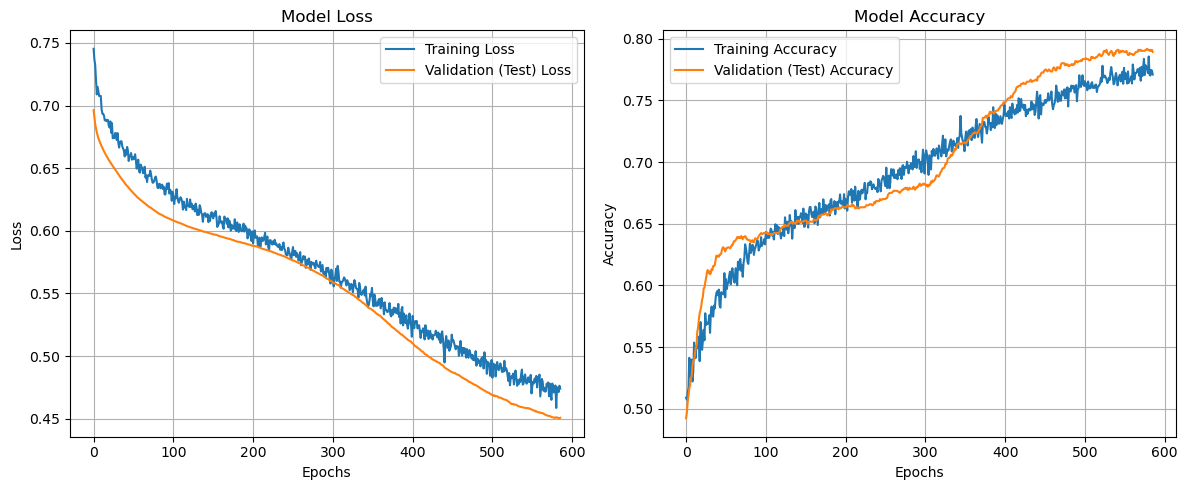

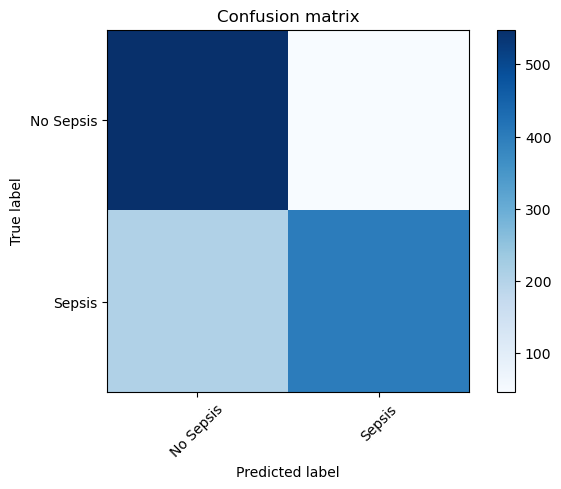

In [83]:
checkpointer = ModelCheckpoint("model_2_fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")



plt.figure(figsize=(12, 5))

#loss Ppot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

This model takes a lot of time to learn

## Model 1

Reduce the amount of layers, remove harsh dropout from every layer exept for the first and change it to 0.2

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4781 - loss: 0.7309 - val_accuracy: 0.4958 - val_loss: 0.7128
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.5033 - loss: 0.7192 - val_accuracy: 0.5183 - val_loss: 0.7031
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.5102 - loss: 0.7109 - val_accuracy: 0.5300 - val_loss: 0.6956
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.5333 - loss: 0.7020 - val_accuracy: 0.5375 - val_loss: 0.6895
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.5319 - loss: 0.6939 - val_accuracy: 0.5492 - val_loss: 0.6845
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.5327 - loss: 0.6942 - val_accuracy: 0.5467 - val_loss: 0.6799
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.5442 - loss: 0.6888 - val_accuracy: 0.5508 - val_loss: 0.6757
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5423 - loss: 0.6854 - val_accura

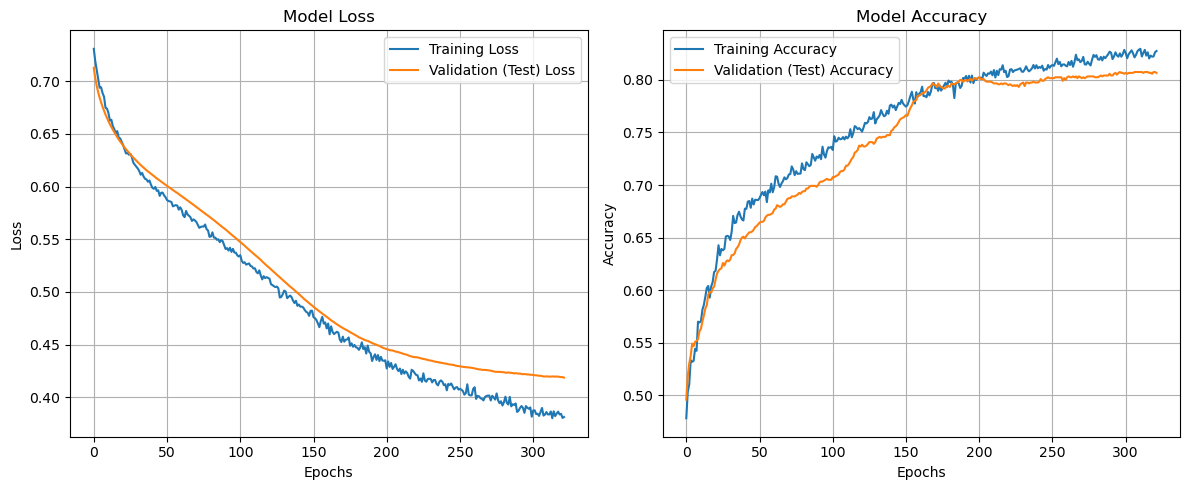

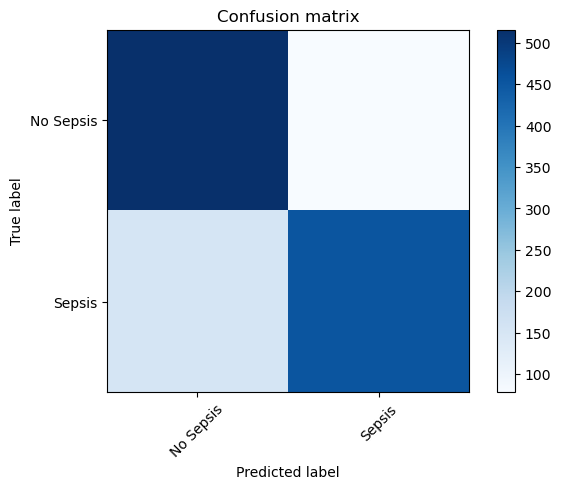

In [84]:
checkpointer = ModelCheckpoint("model_less_layer_fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

#loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

## Model 2


Use less neurons and replace normal ReLu with leaky ReLu to prevent "dead neurons".

In [85]:
from tensorflow.keras.layers import LeakyReLU

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5031 - loss: 0.6866 - val_accuracy: 0.4933 - val_loss: 0.6843
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.5013 - loss: 0.6863 - val_accuracy: 0.4925 - val_loss: 0.6835
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.5063 - loss: 0.6851 - val_accuracy: 0.4983 - val_loss: 0.6827
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5194 - loss: 0.6842 - val_accuracy: 0.5025 - val_loss: 0.6819
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.5215 - loss: 0.6829 - val_accuracy: 0.5117 - val_loss: 0.6810
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.5292 - loss: 0.6817 - val_accuracy: 0.5200 - val_loss: 0.6802
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.5223 - loss: 0.6825 - val_accuracy: 0.5258 - val_loss: 0.6792
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.5312 - loss: 0.6800 - val_accu

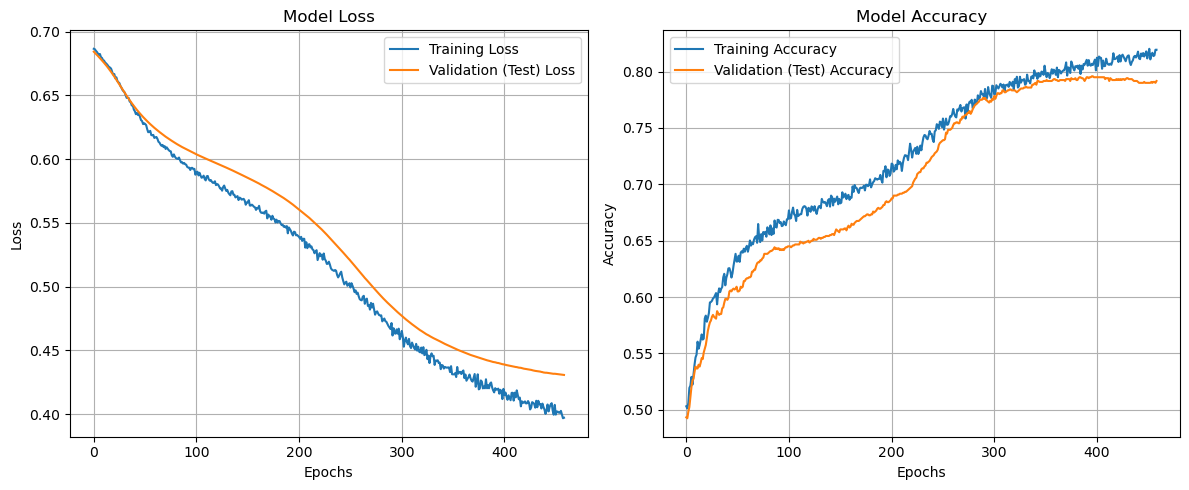

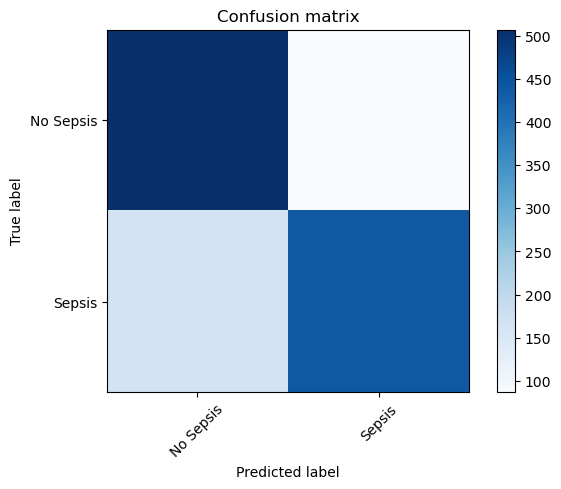

In [86]:
checkpointer = ModelCheckpoint("model_layer_leakyRelu_learning_fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(32, input_dim=x_train.shape[1]))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(16))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(8))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

#loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

## Model 3

Use less layers

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4800 - loss: 0.7788 - val_accuracy: 0.4992 - val_loss: 0.7400
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.4883 - loss: 0.7533 - val_accuracy: 0.5042 - val_loss: 0.7221
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.4902 - loss: 0.7373 - val_accuracy: 0.5150 - val_loss: 0.7080
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 695us/step - accuracy: 0.4967 - loss: 0.7198 - val_accuracy: 0.5167 - val_loss: 0.6966
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 703us/step - accuracy: 0.5033 - loss: 0.7041 - val_accuracy: 0.5192 - val_loss: 0.6872
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.5119 - loss: 0.6974 - val_accuracy: 0.5242 - val_loss: 0.6793
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.5210 - loss: 0.6875 - val_accuracy: 0.5317 - val_loss: 0.6725
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.5260 - loss: 0.6787 - val_accu

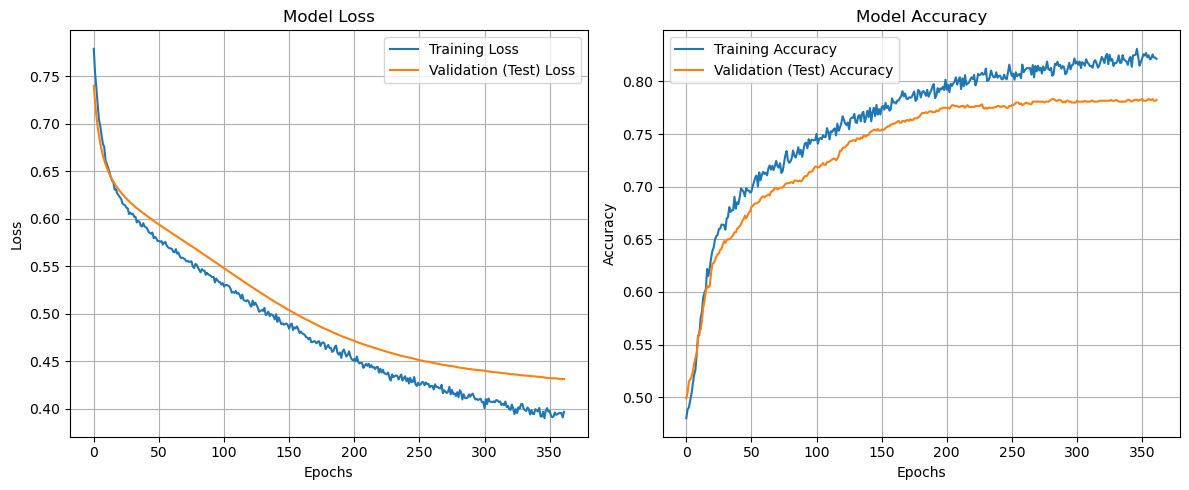

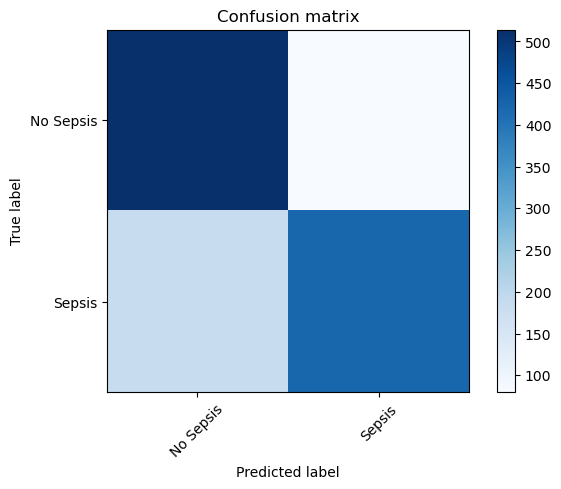

In [87]:
checkpointer = ModelCheckpoint("model_5_fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1]))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.2))

model.add(Dense(32))
model.add(LeakyReLU(alpha=0.1))

#model.add(Dense(32))
#model.add(LeakyReLU(alpha=0.1))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

#loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

Outcome: Model 2 remains the best

## Model 4

- Use normal ReLu
- Start with bigger learning rate and heavier momentum to "roll" better through the loss landscape without getting stuck easily
- Learning rate reduce on plateau

In [47]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import roc_curve, auc

Epoch 1/10000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5275 - loss: 0.6999 - val_accuracy: 0.5725 - val_loss: 0.6726 - learning_rate: 0.0100
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.5929 - loss: 0.6633 - val_accuracy: 0.6042 - val_loss: 0.6506 - learning_rate: 0.0100
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.6360 - loss: 0.6302 - val_accuracy: 0.6158 - val_loss: 0.6339 - learning_rate: 0.0100
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.6431 - loss: 0.6221 - val_accuracy: 0.6283 - val_loss: 0.6224 - learning_rate: 0.0100
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.6787 - loss: 0.6028 - val_accuracy: 0.6333 - val_loss: 0.6131 - learning_rate: 0.0100
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.6882 - loss: 0.5901 - val_accuracy: 0.6467 - val_loss: 0.6052 - learning_rate: 0.0100
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.6825 - loss: 0.58

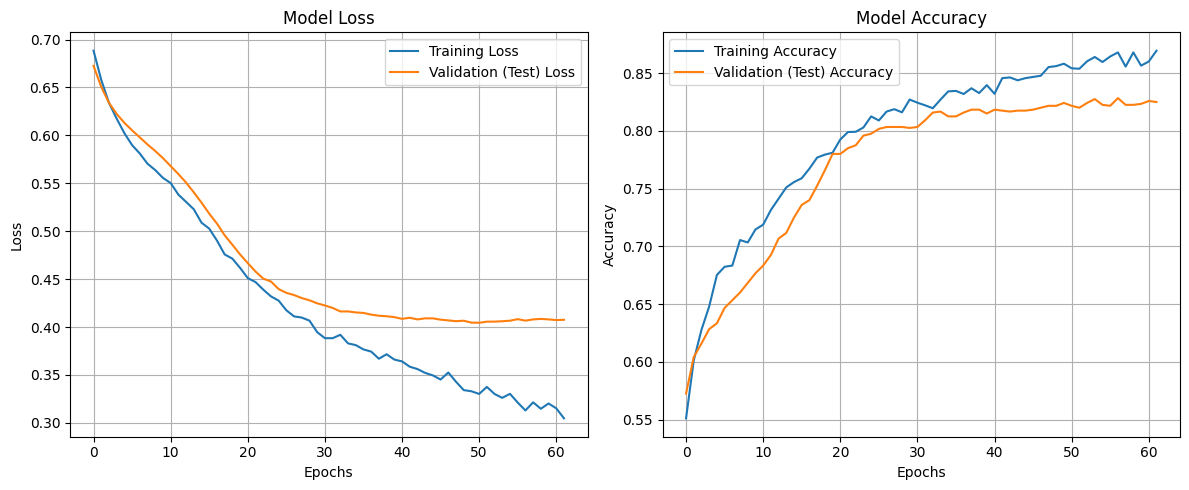

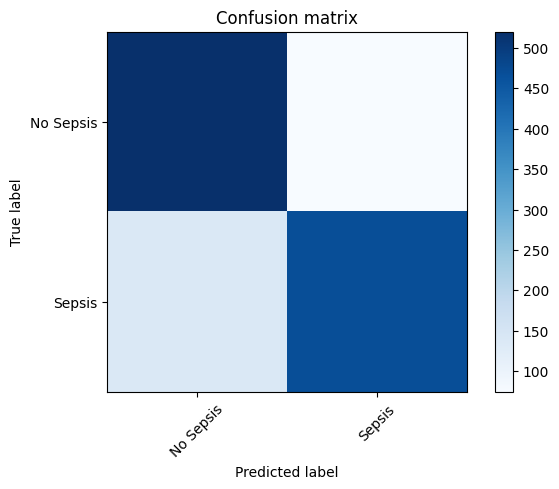

In [57]:
checkpointer = ModelCheckpoint("model_less_layer_fcn-best_weights.keras", verbose=0, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,             
    verbose=1          
)
best_val_loss = float('inf')
best_model = None

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.1), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=12, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer, lr_scheduler], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

#loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()


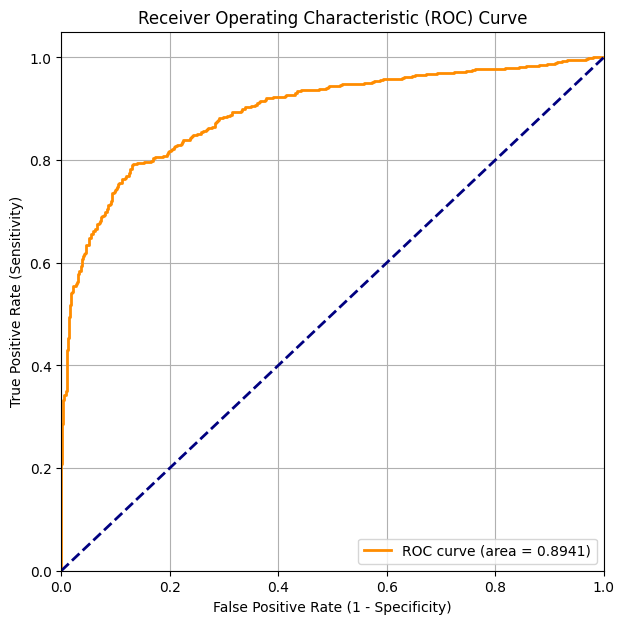

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

#plotting the ROC Curve
plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

## Model 5

Use Adam Optimizer

In [14]:
from tensorflow.keras.optimizers import Adam

Epoch 1/10000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5336 - loss: 0.7320 - val_accuracy: 0.6417 - val_loss: 0.6263
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6301 - loss: 0.6234 - val_accuracy: 0.6733 - val_loss: 0.5852
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.5855 - val_accuracy: 0.7375 - val_loss: 0.5341
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7281 - loss: 0.5354 - val_accuracy: 0.7892 - val_loss: 0.4683
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7768 - loss: 0.4776 - val_accuracy: 0.8042 - val_loss: 0.4458
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7977 - loss: 0.4401 - val_accuracy: 0.8042 - val_loss: 0.4305
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8025 - loss: 0.4214 - val_accuracy: 0.8117 - val_loss: 0.4184
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8166 - loss: 0.4105 - val_accuracy: 0.8142 -

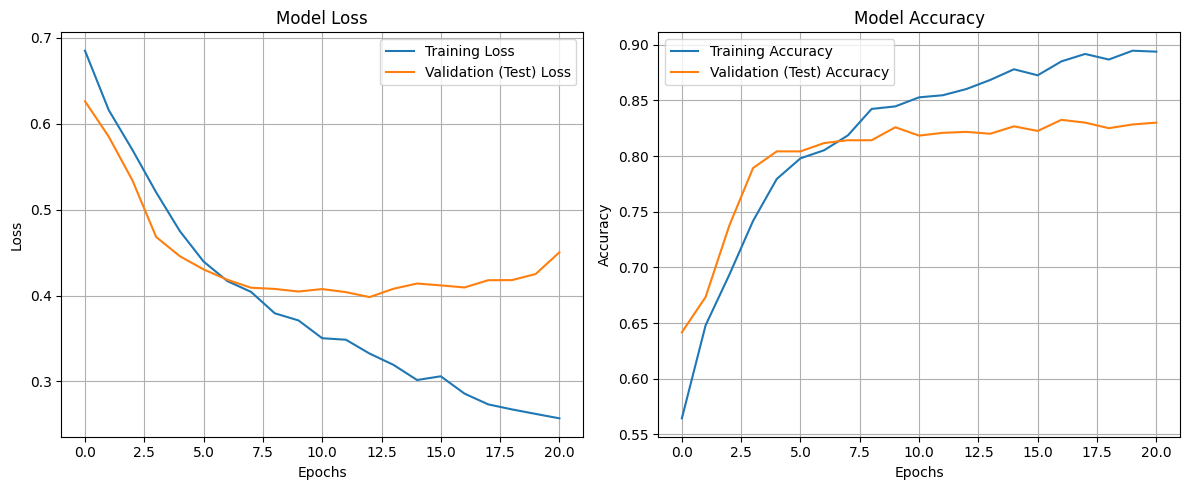

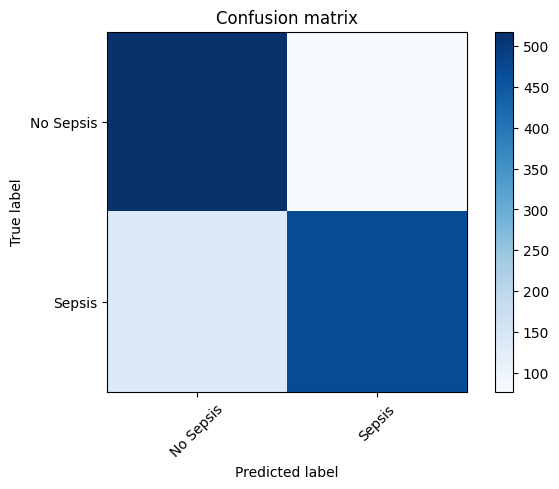

In [26]:
checkpointer = ModelCheckpoint("model_less_layer_fcn-best_weights.keras", verbose=0, save_best_only=True)

best_val_loss = float('inf')
best_model = None


model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=8, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

#loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()


## Model 6

A model with significantly more neurons

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5962 - loss: 0.7449 - val_accuracy: 0.6317 - val_loss: 0.6221 - learning_rate: 0.0100
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6496 - loss: 0.6586 - val_accuracy: 0.6125 - val_loss: 0.6604 - learning_rate: 0.0100
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6756 - loss: 0.6192 - val_accuracy: 0.6100 - val_loss: 0.6840 - learning_rate: 0.0100
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6775 - loss: 0.6081 - val_accuracy: 0.6250 - val_loss: 0.6674 - learning_rate: 0.0100
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7021 - loss: 0.5786 - val_accuracy: 0.6342 - val_loss: 0.6612 - learning_rate: 0.0100
Epoch 6/10000
42/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6933 - loss: 0.5852
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7058 - loss: 0.5684 - val_accuracy

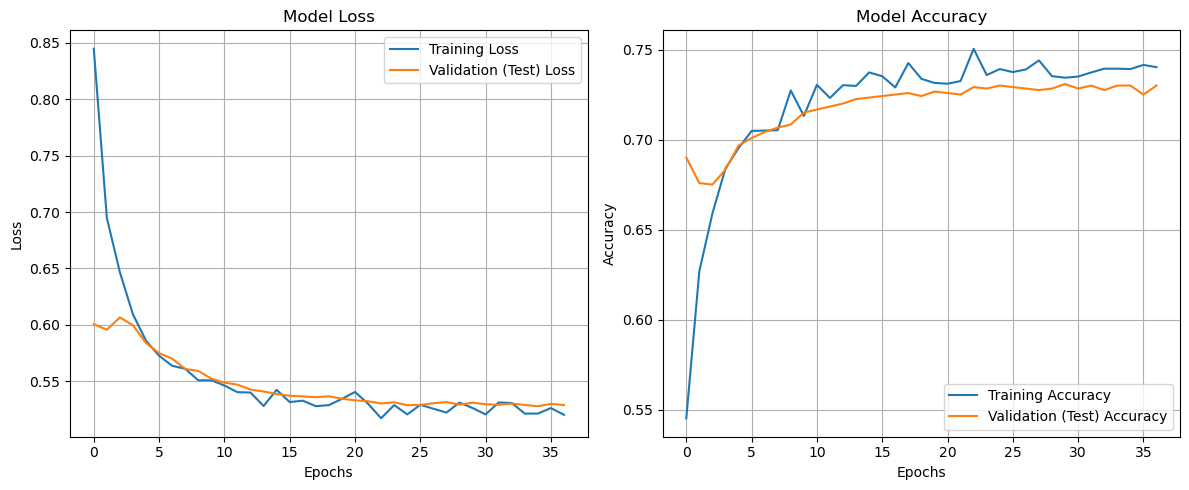

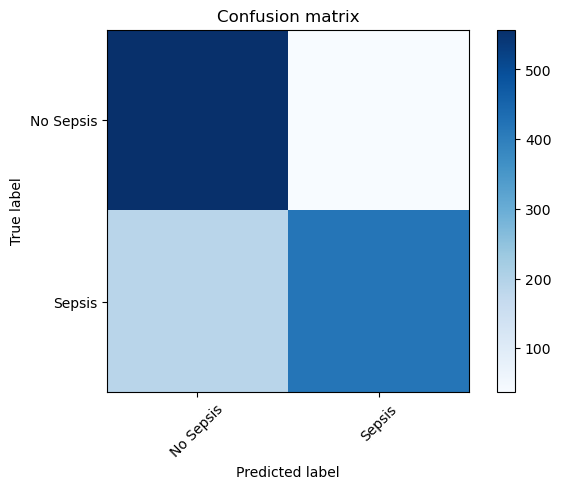

In [92]:
checkpointer = ModelCheckpoint("deeper_model-best_weights.keras", verbose=0, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,             
    verbose=1          
)
best_val_loss = float('inf')
best_model = None

for i in range (5):
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1], activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(128, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(64, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Dense(32, activation="relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.1), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=12, verbose=2, mode='min', restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer, lr_scheduler], verbose=1, epochs=10000)

    #track best model across runs by val loss
    val_loss = min(history.history['val_loss'])
    print(f"  Run val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

#loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()


## Testing The Value Of Undersampling (EC : 1)

Without Undersampling (first 6000 entries from dataset A)

In [93]:
patients = {}
j = 1

#add in non sepsis patients from dataset A for a total of 6000
for i in range (0,20643):
    if j > 6000:
        break
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        key = f"p{j:06d}"
        patients[key] = temp
        j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")

#number of patients in dataset        
numPatients = (len(patients))
print(numPatients)

6000


In [94]:
#define how many time entries per patient
WINDOW_SIZE = 8 
#columns to be dropped
DROP_COLS = ['Bilirubin_direct', 'Bilirubin_total', 'TroponinI', 'Fibrinogen', 'Unit1', 'Unit2', 'EtCO2', 'SepsisLabel']

preparedPatients = []
labels = []

for i in range(1, 6001):
    temp = patients[f"p{i:06d}"]
    temp = temp.drop(DROP_COLS, axis=1) #drop unneccessary fields and SepsisLabel
    temp = temp.fillna(global_means) #fill NaNs with global means
    
    feat_cols = temp.columns
    temp = (temp - global_means[feat_cols]) / global_stds[feat_cols]
    
    #pad with global mean values for each column if patient has fewer than WINDOW_SIZE rows
    if len(temp) < WINDOW_SIZE:
        padding = pd.DataFrame(
            np.zeros((WINDOW_SIZE - len(temp), len(feat_cols))),
            columns=feat_cols
        )
        temp = pd.concat([temp, padding], ignore_index=True)
    
    #take WINDOW_SIZE rows from end and flatten to 1D
    window = temp.iloc[-WINDOW_SIZE:].values.astype(np.float32)
    preparedPatients.append(window.flatten())
    
    #overwrite sepsis label with last label 
    labels.append(patients[f"p{i:06d}"]['SepsisLabel'].iloc[-1])

#set x and y values (not using to_xy())
x = np.array(preparedPatients, dtype=np.float32)
y = np.array(labels, dtype=np.float32)

In [95]:
#91% non-sepsis patients
sepsis_count = int(np.sum(y == 1))
no_sepsis_count = int(np.sum(y == 0))
total = len(y)
print(f"Sepsis (1):     {sepsis_count} ({sepsis_count/total*100:.1f}%)")
print(f"No Sepsis (0):  {no_sepsis_count} ({no_sepsis_count/total*100:.1f}%)")
print(f"Total:          {total}")

Sepsis (1):     537 (8.9%)
No Sepsis (0):  5463 (91.0%)
Total:          6000


In [96]:
#train test split, 80/20 split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=True)

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4863 - loss: 0.7347 - val_accuracy: 0.5858 - val_loss: 0.6834
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.6087 - loss: 0.6777 - val_accuracy: 0.8108 - val_loss: 0.6457
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.6988 - loss: 0.6386 - val_accuracy: 0.8917 - val_loss: 0.6135
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.7473 - loss: 0.6116 - val_accuracy: 0.9117 - val_loss: 0.5852
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.7994 - loss: 0.5784 - val_accuracy: 0.9142 - val_loss: 0.5602
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.8348 - loss: 0.5581 - val_accuracy: 0.9150 - val_loss: 0.5380
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.8548 - loss: 0.5398 - val_accuracy: 0.9158 - val_loss: 0.5184
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.8712 - loss: 0.5175 - val_accu

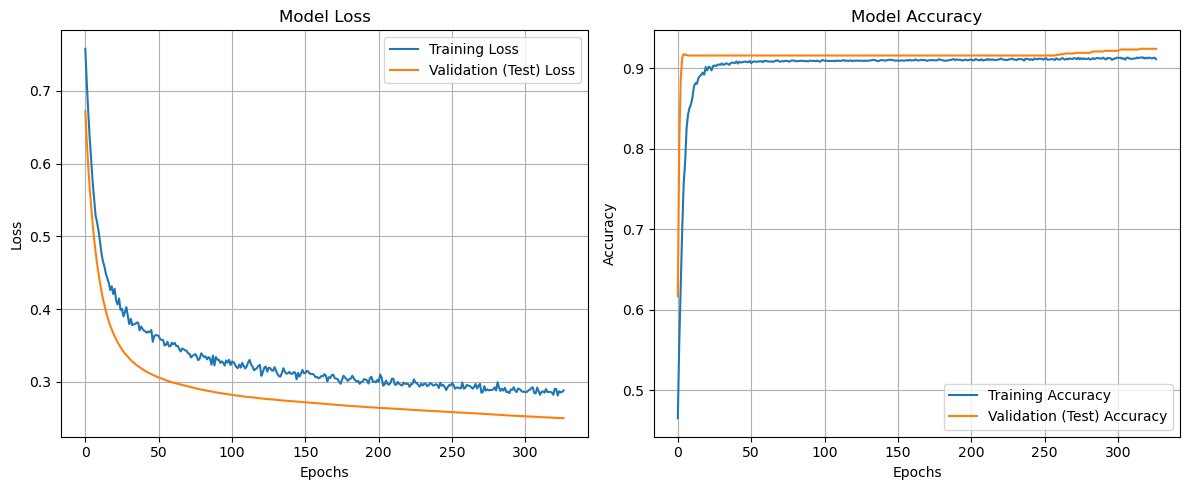

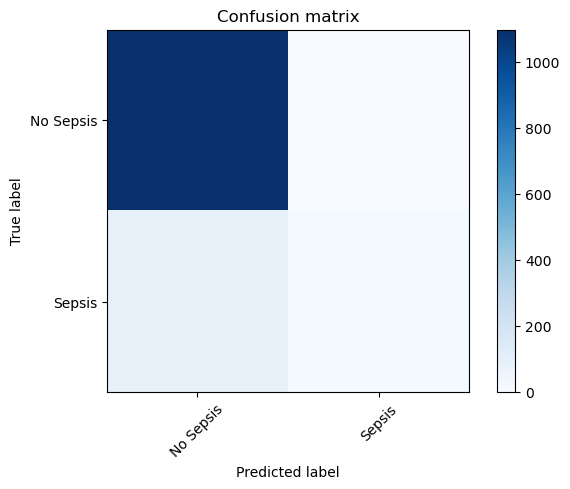

In [97]:
#The same first model to test against first downsampled implementation (score to beat is 0.8731)
checkpointer = ModelCheckpoint("model_2_fcn-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None

for i in range (5):
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

    #track best model across runs by val loss
    val_loss = min(history.history['val_loss'])
    print(f"  Run val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")



plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

As visible from this confusion matrix, we can clearly see that having significantly less Sepsis patients to train on leads to the model not having sufficient information about what defines a sepsis patient, meaning that the model defaults to consistantly prediction no sepsis for both sepsis and non sepsis patients.  This confirms the working theory that undersampling is the correct approach for this dataset.

## Testig Class Weights (EC:2)

On our best model so far, we are implementing different class weights. Since detecting a sepsis patient and not overseeing any sepsis cases is the most important case, we are setting the class weight of sepsis to 1.8 the amount compared to the non-sepsis class.

In [45]:
#define weights: Class 0 (non-sepsis) remains the same = 1.0
#class 1 (sepsis) is 1.8 times as important as non-sepsis
class_weight = {
    0: 1.0,
    1: 1.8
}

Epoch 1/10000


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5267 - loss: 0.8454 - val_accuracy: 0.5342 - val_loss: 0.6566 - learning_rate: 0.0100
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5407 - loss: 0.7937 - val_accuracy: 0.5550 - val_loss: 0.6368 - learning_rate: 0.0100
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5720 - loss: 0.7701 - val_accuracy: 0.5933 - val_loss: 0.6184 - learning_rate: 0.0100
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6142 - loss: 0.7545 - val_accuracy: 0.6167 - val_loss: 0.6042 - learning_rate: 0.0100
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 0.7434 - val_accuracy: 0.6400 - val_loss: 0.5888 - learning_rate: 0.0100
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6569 - loss: 0.7197 - val_accuracy: 0.6650 - val_loss: 0.5735 - learning_rate: 0.0100
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6745 - loss: 0.7041 - val_acc

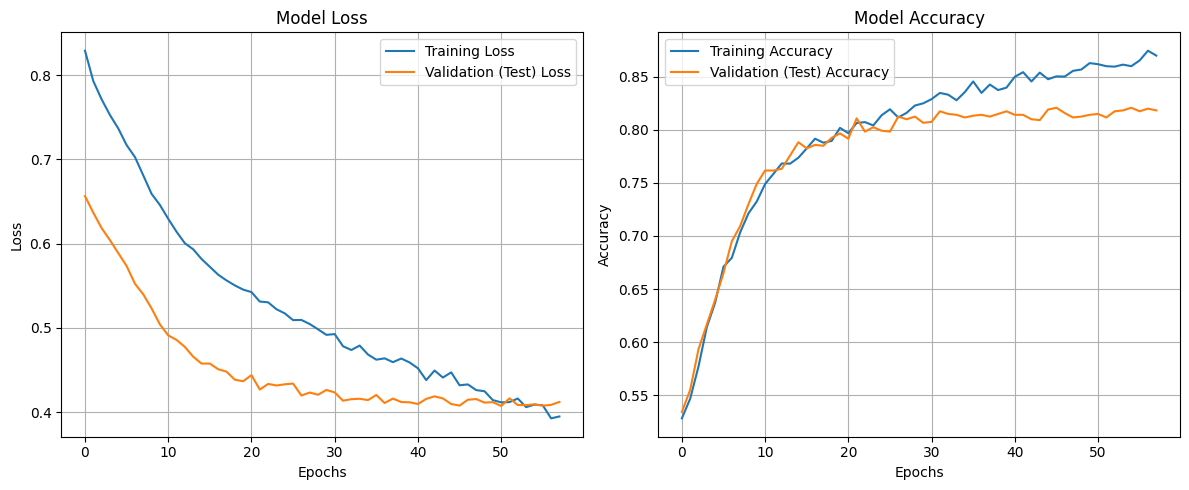

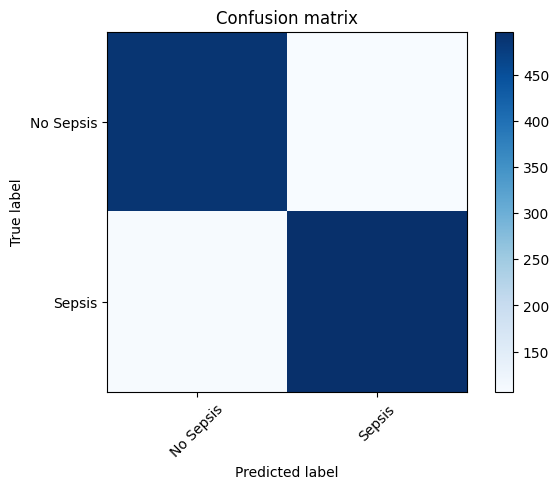

In [46]:
checkpointer = ModelCheckpoint("model_less_layer_fcn-best_weights.keras", verbose=0, save_best_only=True)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         
    patience=5,             
    verbose=1          
)
best_val_loss = float('inf')
best_model = None

model = Sequential()
model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.1), metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=12, verbose=2, mode='min', restore_best_weights=True)
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, class_weight=class_weight, callbacks=[monitor, checkpointer, lr_scheduler], verbose=1, epochs=10000)

#track best model across runs by val loss
val_loss = min(history.history['val_loss'])
print(f"  Run val loss: {val_loss:.4f}")
if val_loss < best_val_loss:
    best_val_loss = val_loss
    best_model = model
    print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")


plt.figure(figsize=(12, 5))

#loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

#accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()


## Testing Various Window Sizes (EC:4)

Reload Data (With Undersampling)

In [102]:
#considering that there are many more patients without sepsis than with sepsis,
#it will help balance results to get every instance of sepsis

#get every instance of patient with sepsis in both datasets, put in a library
patients = {}
j = 1

#dataset A
for i in range (0,20644):
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        #if the patient has sepsis, store in library
        if temp['SepsisLabel'].iloc[-1] == 1:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
        
#dataset B
for i in range (100000,120001):
    try:
        filename = f"CC-2019-Sepsis/training_setB/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        #if the patient has sepsis, store in library
        if temp['SepsisLabel'].iloc[-1] == 1:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
        
#number of sepsis patients found        
numSepsisPatients = (len(patients))

#add in non sepsis patients from dataset A for a total of 6000
for i in range (0,20643):
    if j > 6000:
        break
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        if temp['SepsisLabel'].iloc[-1] == 0:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")

In [105]:
def prepareData(windowSize):
    DROP_COLS = ['Bilirubin_direct', 'Bilirubin_total', 'TroponinI', 'Fibrinogen', 'Unit1', 'Unit2', 'EtCO2', 'SepsisLabel']
    preparedPatients = []
    labels = []

    for i in range(1, 6001):
        temp = patients[f"p{i:06d}"].copy() 
        temp = temp.drop(DROP_COLS, axis=1)
        temp = temp.fillna(global_means)
    
        feat_cols = temp.columns
        temp = (temp - global_means[feat_cols]) / global_stds[feat_cols]
    
        if len(temp) < windowSize:
            padding = pd.DataFrame(
                np.zeros((windowSize - len(temp), len(feat_cols))),
                columns=feat_cols
            )
            temp = pd.concat([temp, padding], ignore_index=True)
    
        window = temp.iloc[-windowSize:].values.astype(np.float32)
        preparedPatients.append(window.flatten())
        labels.append(patients[f"p{i:06d}"]['SepsisLabel'].iloc[-1])

    x = np.array(preparedPatients, dtype=np.float32)
    y = np.array(labels, dtype=np.float32)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=True)
    
    return x_train, x_test, y_train, y_test

The goal is to test using window sizes 5, 8, 10, 15 and 20 and determine which performs the best

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5044 - loss: 0.7006 - val_accuracy: 0.5083 - val_loss: 0.6826
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.4946 - loss: 0.6966 - val_accuracy: 0.5158 - val_loss: 0.6819
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.5017 - loss: 0.6974 - val_accuracy: 0.5208 - val_loss: 0.6811
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.5079 - loss: 0.6956 - val_accuracy: 0.5267 - val_loss: 0.6804
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.5100 - loss: 0.6929 - val_accuracy: 0.5350 - val_loss: 0.6798
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5077 - loss: 0.6914 - val_accuracy: 0.5350 - val_loss: 0.6791
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.5146 - loss: 0.6893 - val_accuracy: 0.5442 - val_loss: 0.6785
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.5079 - loss: 0.6917 - val_accu

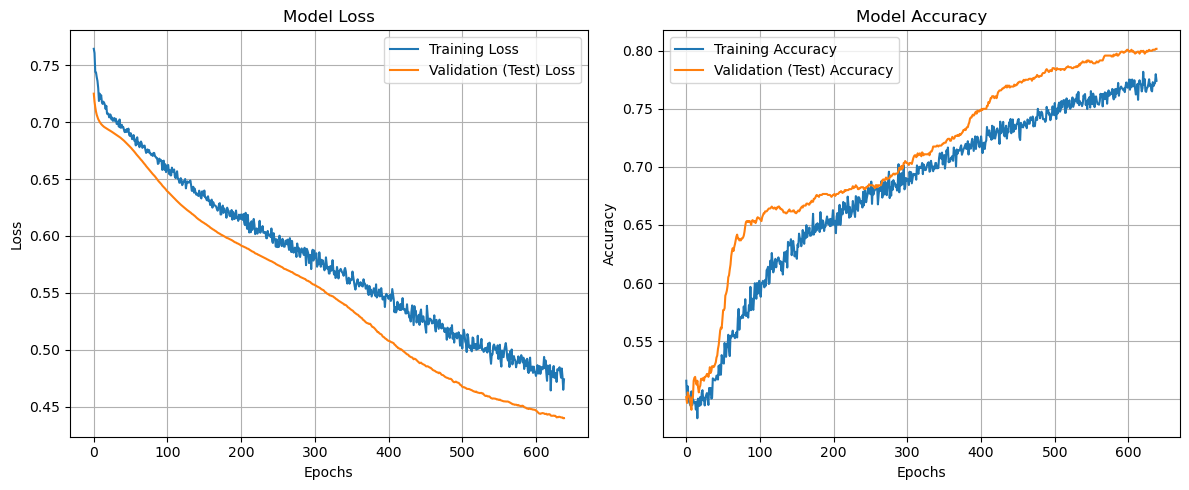

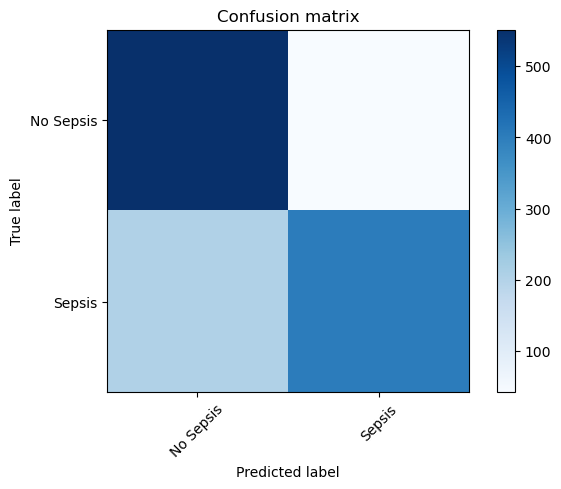

In [106]:
x_train, x_test, y_train, y_test = prepareData(5)
checkpointer = ModelCheckpoint("window5-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None

for i in range (5):
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

    #track best model across runs by val loss
    val_loss = min(history.history['val_loss'])
    print(f"  Run val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")



plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5085 - loss: 0.7718 - val_accuracy: 0.4883 - val_loss: 0.7253
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.5117 - loss: 0.7526 - val_accuracy: 0.4867 - val_loss: 0.7126
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.5071 - loss: 0.7383 - val_accuracy: 0.4950 - val_loss: 0.7046
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.4958 - loss: 0.7320 - val_accuracy: 0.5058 - val_loss: 0.6986
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.5185 - loss: 0.7158 - val_accuracy: 0.5225 - val_loss: 0.6942
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.5050 - loss: 0.7176 - val_accuracy: 0.5275 - val_loss: 0.6904
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.5058 - loss: 0.7134 - val_accuracy: 0.5392 - val_loss: 0.6876
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.5067 - loss: 0.7097 - val_accu

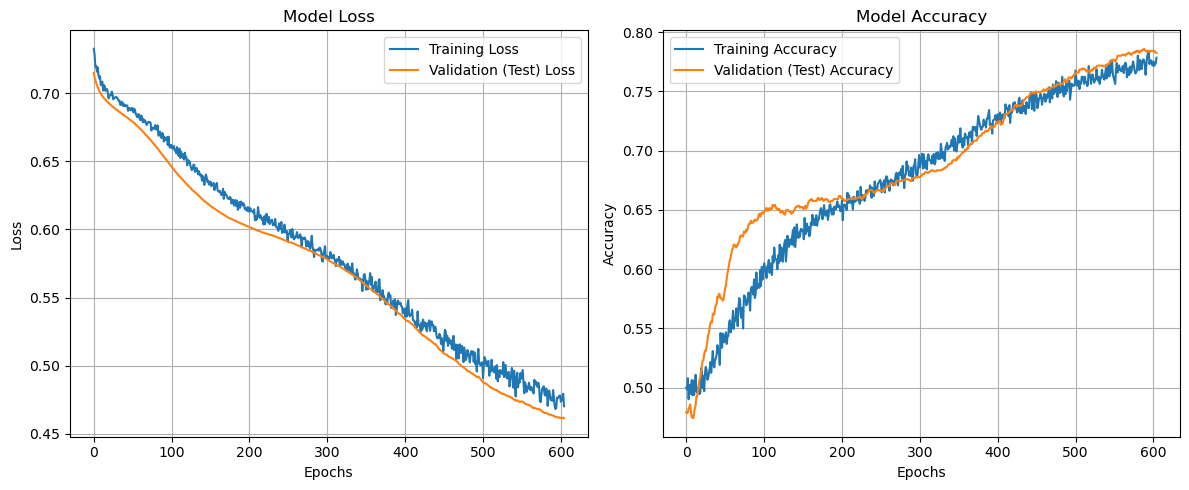

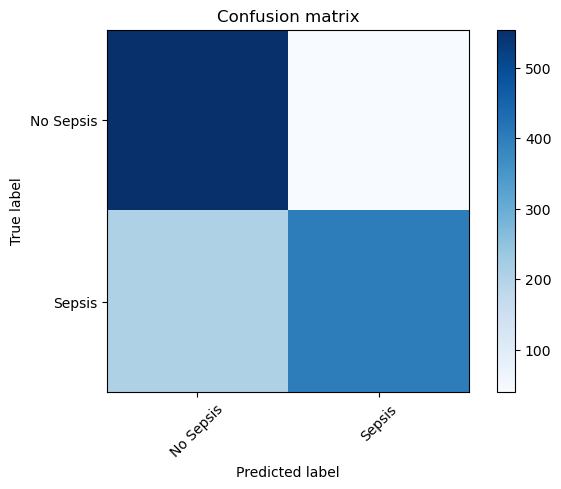

In [107]:
x_train, x_test, y_train, y_test = prepareData(8)
checkpointer = ModelCheckpoint("window8-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None

for i in range (5):
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

    #track best model across runs by val loss
    val_loss = min(history.history['val_loss'])
    print(f"  Run val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")



plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4998 - loss: 0.7237 - val_accuracy: 0.4975 - val_loss: 0.6940
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.5092 - loss: 0.7195 - val_accuracy: 0.5067 - val_loss: 0.6907
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.5131 - loss: 0.7121 - val_accuracy: 0.5125 - val_loss: 0.6878
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - accuracy: 0.5119 - loss: 0.7133 - val_accuracy: 0.5142 - val_loss: 0.6849
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.5208 - loss: 0.7076 - val_accuracy: 0.5233 - val_loss: 0.6822
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - accuracy: 0.5200 - loss: 0.7024 - val_accuracy: 0.5308 - val_loss: 0.6797
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5285 - loss: 0.7004 - val_accuracy: 0.5375 - val_loss: 0.6772
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.5292 - loss: 0.6972 - val_accu

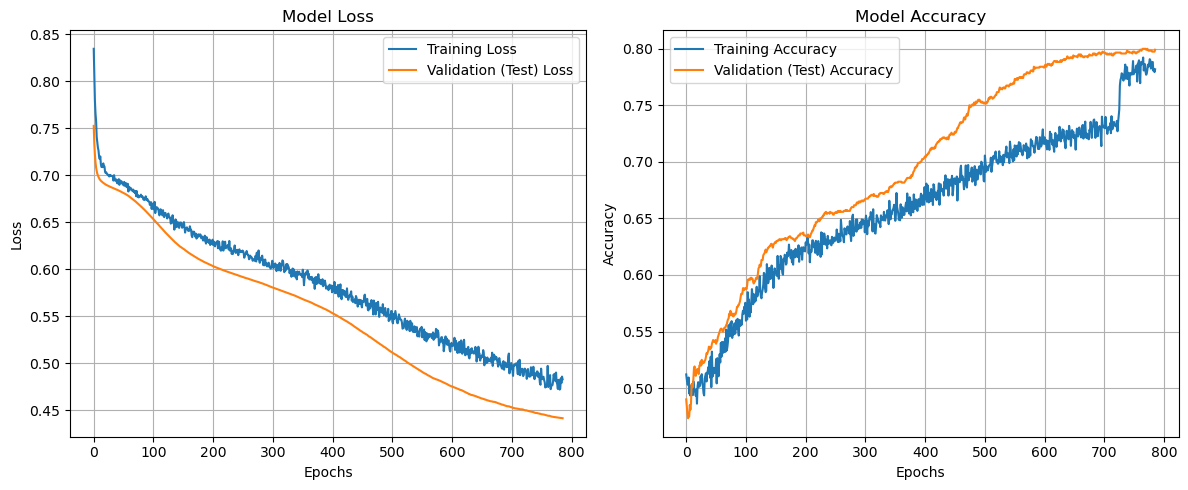

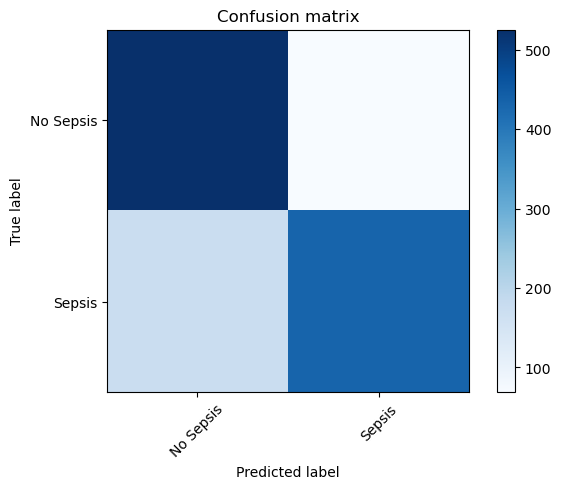

In [108]:
x_train, x_test, y_train, y_test = prepareData(10)
checkpointer = ModelCheckpoint("window10-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None

for i in range (5):
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

    #track best model across runs by val loss
    val_loss = min(history.history['val_loss'])
    print(f"  Run val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")



plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5277 - loss: 0.7099 - val_accuracy: 0.5442 - val_loss: 0.6807
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5321 - loss: 0.7049 - val_accuracy: 0.5467 - val_loss: 0.6771
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.5469 - loss: 0.6962 - val_accuracy: 0.5500 - val_loss: 0.6744
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.5540 - loss: 0.6926 - val_accuracy: 0.5558 - val_loss: 0.6716
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.5440 - loss: 0.6911 - val_accuracy: 0.5575 - val_loss: 0.6694
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.5446 - loss: 0.6922 - val_accuracy: 0.5550 - val_loss: 0.6672
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.5410 - loss: 0.6924 - val_accuracy: 0.5617 - val_loss: 0.6652
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.5529 - loss: 0.6856 - val_accura

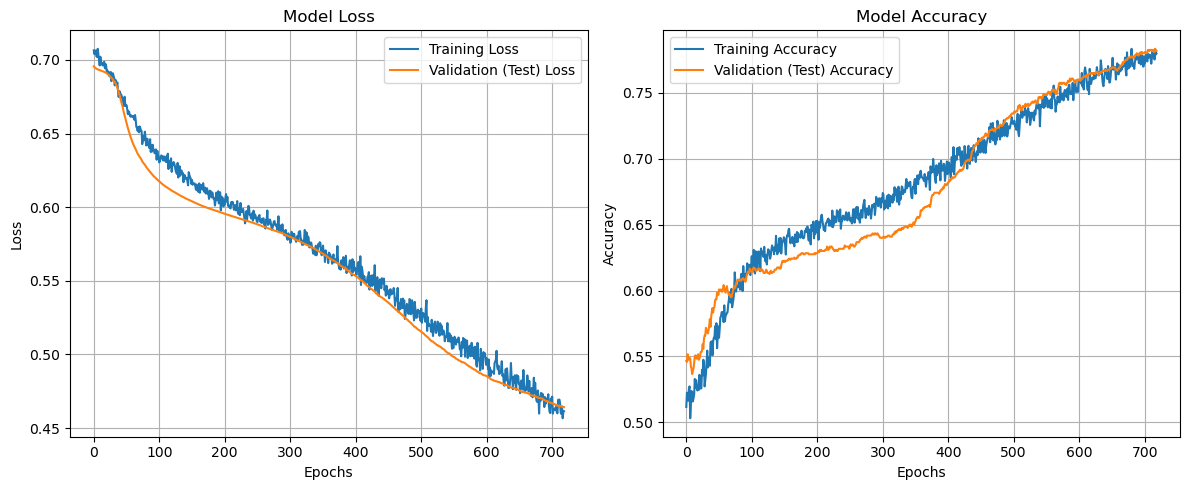

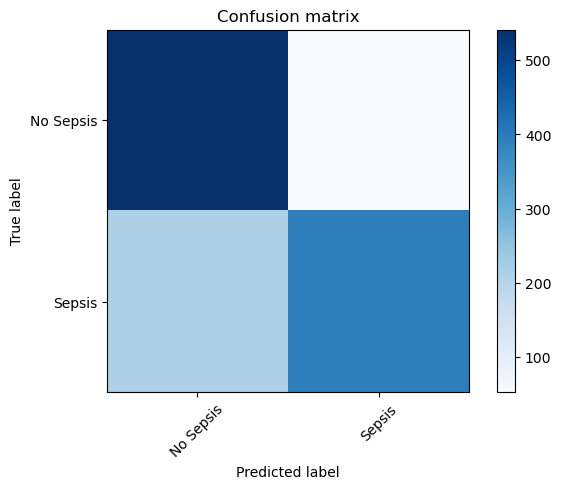

In [ ]:
x_train, x_test, y_train, y_test = prepareData(15)
checkpointer = ModelCheckpoint("window15-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None

for i in range (5):
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

    #track best model across runs by val loss
    val_loss = min(history.history['val_loss'])
    print(f"  Run val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")



plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

Epoch 1/10000


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4950 - loss: 0.7277 - val_accuracy: 0.5133 - val_loss: 0.6946
Epoch 2/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.5046 - loss: 0.7173 - val_accuracy: 0.5267 - val_loss: 0.6879
Epoch 3/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.5113 - loss: 0.7092 - val_accuracy: 0.5433 - val_loss: 0.6825
Epoch 4/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.5179 - loss: 0.7092 - val_accuracy: 0.5517 - val_loss: 0.6778
Epoch 5/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.5292 - loss: 0.6977 - val_accuracy: 0.5617 - val_loss: 0.6735
Epoch 6/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.5250 - loss: 0.6999 - val_accuracy: 0.5667 - val_loss: 0.6702
Epoch 7/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.5254 - loss: 0.6983 - val_accuracy: 0.5750 - val_loss: 0.6675
Epoch 8/10000
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.5344 - loss: 0.6934 - val_accu

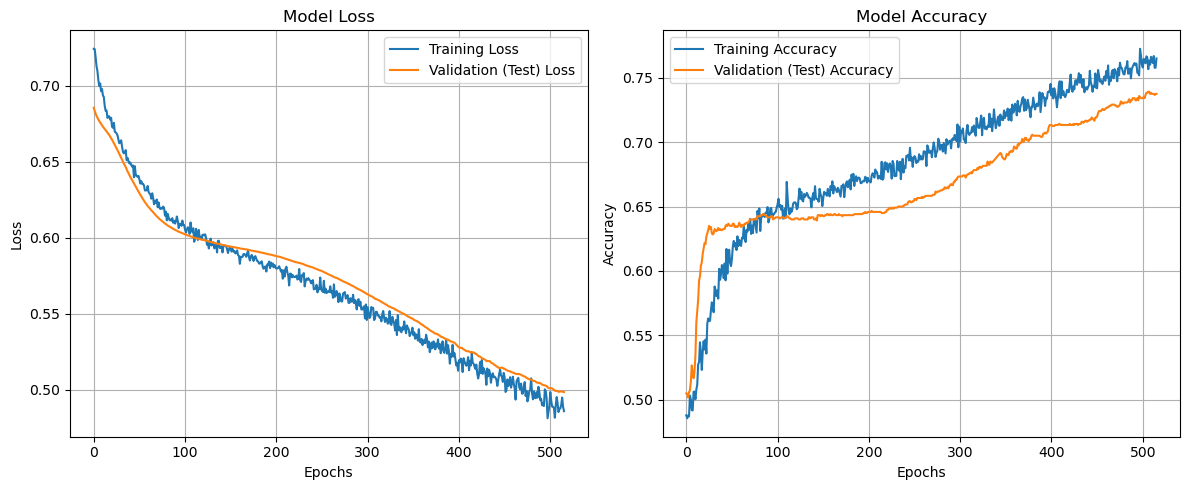

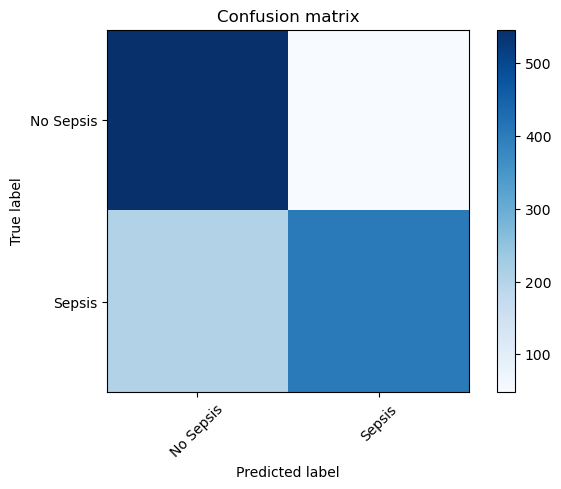

In [110]:
x_train, x_test, y_train, y_test = prepareData(20)
#The same first model to test against first downsampled implementation (score to beat is 0.8731)
checkpointer = ModelCheckpoint("window20-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None

for i in range (5):
    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=SGD(learning_rate=0.001, momentum=0.01), metrics=['accuracy'])
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=10, verbose=2, mode='min', restore_best_weights=True)
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=64, callbacks=[monitor, checkpointer], verbose=1, epochs=10000)

    #track best model across runs by val loss
    val_loss = min(history.history['val_loss'])
    print(f"  Run val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")



plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation (Test) Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation (Test) Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'])
plt.show()

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Window Size 5: ROC AUC = 0.8810
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Window Size 8: ROC AUC = 0.8729
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 762us/step


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Window Size 10: ROC AUC = 0.8740
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Window Size 15: ROC AUC = 0.8629
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step
Window Size 20: ROC AUC = 0.8671


/opt/anaconda3/lib/python3.13/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


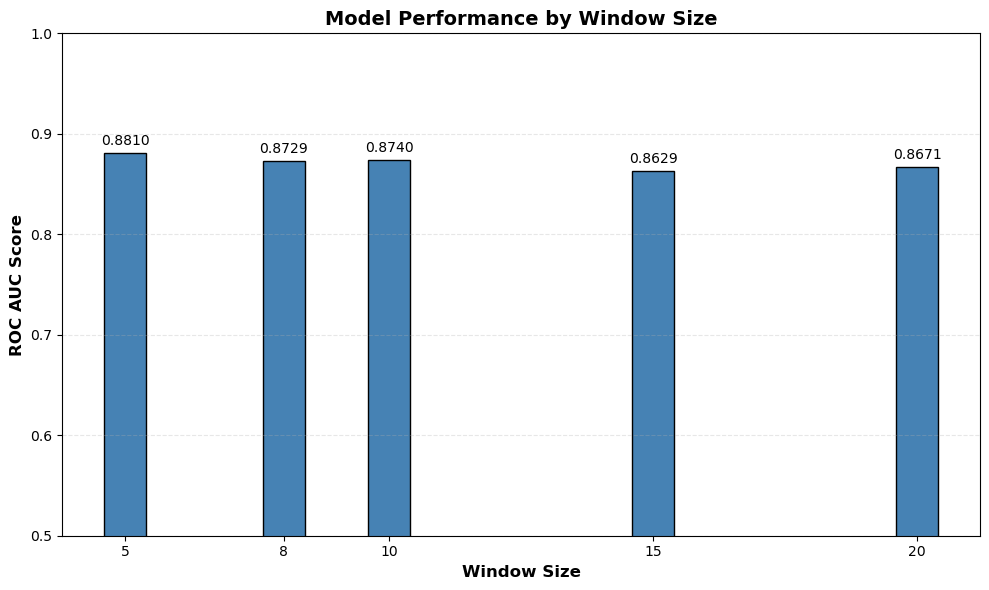


SUMMARY
Best Window Size: 5
Best ROC AUC:     0.8810


In [111]:
#Comparison
window_sizes = [5, 8, 10, 15, 20]
auc_scores = []

for WINDOW_SIZE in window_sizes:
    x_train, x_test, y_train, y_test = prepareData(WINDOW_SIZE)

    model = Sequential()
    model.add(Dense(64, input_dim=x_train.shape[1], activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.load_weights(f"window{WINDOW_SIZE}-best_weights.keras")

    y_pred_prob = model.predict(x_test)
    auc = roc_auc_score(y_test, y_pred_prob)
    auc_scores.append(auc)
    print(f"Window Size {WINDOW_SIZE}: ROC AUC = {auc:.4f}")

# Bar Graph
plt.figure(figsize=(10, 6))
bars = plt.bar(window_sizes, auc_scores, color='steelblue', edgecolor='black')
plt.xlabel('Window Size', fontsize=12, fontweight='bold')
plt.ylabel('ROC AUC Score', fontsize=12, fontweight='bold')
plt.title('Model Performance by Window Size', fontsize=14, fontweight='bold')
plt.xticks(window_sizes)
plt.ylim(0.5, 1.0)
plt.grid(axis='y', alpha=0.3, linestyle='--')
for bar, score in zip(bars, auc_scores):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005,
             f'{score:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

print("\nSUMMARY")
best_idx = np.argmax(auc_scores)
print(f"Best Window Size: {window_sizes[best_idx]}")
print(f"Best ROC AUC:     {auc_scores[best_idx]:.4f}")

Based on this, it's somewhat inconclusive which window size performs the best for the FCNN.  It seems as though it gets slightly better as window size increases but RMSE values are generally in the same range

## For Fun, LSTM Implementation (Data over time analysis)

In [116]:
#considering that there are many more patients without sepsis than with sepsis,
#it will help balance results to get every instance of sepsis

#get every instance of patient with sepsis in both datasets, put in a library
patients = {}
j = 1

#dataset A
for i in range (0,20644):
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        #if the patient has sepsis, store in library
        if temp['SepsisLabel'].iloc[-1] == 1:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
        
#dataset B
for i in range (100000,120001):
    try:
        filename = f"CC-2019-Sepsis/training_setB/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        #if the patient has sepsis, store in library
        if temp['SepsisLabel'].iloc[-1] == 1:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")
        
#number of sepsis patients found        
numSepsisPatients = (len(patients))

#add in non sepsis patients from dataset A for a total of 6000
for i in range (0,20643):
    if j > 10000:
        break
    try:
        filename = f"CC-2019-Sepsis/training_setA/p{i:06d}.psv"
        temp = pd.read_csv(filename, sep='|')
        if temp['SepsisLabel'].iloc[-1] == 0:
            key = f"p{j:06d}"
            patients[key] = temp
            j += 1
    except FileNotFoundError as e:
        if testing == True:
            print(f"file not found p{i}.psv")

In [119]:
WINDOW_SIZE = 20
DROP_COLS = ['Bilirubin_direct', 'Bilirubin_total', 'TroponinI', 'Fibrinogen',
             'Unit1', 'Unit2', 'EtCO2', 'SepsisLabel']

#data preperation
preparedPatients = []
labels = []

for i in range(1, 10001):
    temp = patients[f"p{i:06d}"].copy()
    temp = temp.drop(DROP_COLS, axis=1)
    temp = temp.fillna(global_means)

    feat_cols = temp.columns
    temp = (temp - global_means[feat_cols]) / global_stds[feat_cols]

    if len(temp) < WINDOW_SIZE:
        padding = pd.DataFrame(
            np.zeros((WINDOW_SIZE - len(temp), len(feat_cols))),
            columns=feat_cols
        )
        temp = pd.concat([temp, padding], ignore_index=True)

    #take WINDOW_SIZE rows, keep as 2D instead of flatten
    window = temp.iloc[-WINDOW_SIZE:].values.astype(np.float32)
    preparedPatients.append(window)
    labels.append(patients[f"p{i:06d}"]['SepsisLabel'].iloc[-1])

#shape: (6000, 20, n_features)
x = np.array(preparedPatients, dtype=np.float32)
y = np.array(labels, dtype=np.float32)

n_features = x.shape[2]
print(f"x shape: {x.shape}, y shape: {y.shape}")

#train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42, shuffle=True)

x shape: (10000, 20, 33), y shape: (10000,)


Epoch 1/10000
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.7924 - loss: 0.4670 - val_accuracy: 0.8405 - val_loss: 0.3935
Epoch 2/10000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8508 - loss: 0.3733 - val_accuracy: 0.8580 - val_loss: 0.3598
Epoch 3/10000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8626 - loss: 0.3489 - val_accuracy: 0.8670 - val_loss: 0.3332
Epoch 4/10000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8737 - loss: 0.3289 - val_accuracy: 0.8760 - val_loss: 0.3283
Epoch 5/10000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8741 - loss: 0.3177 - val_accuracy: 0.8740 - val_loss: 0.3194
Epoch 6/10000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8834 - loss: 0.3029 - val_accuracy: 0.8735 - val_loss: 0.3362
Epoch 7/10000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8856 - loss: 0.2951 - val_accuracy: 0.8750 - val_loss: 0.3261
Epoch 8/10000
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.8909 -

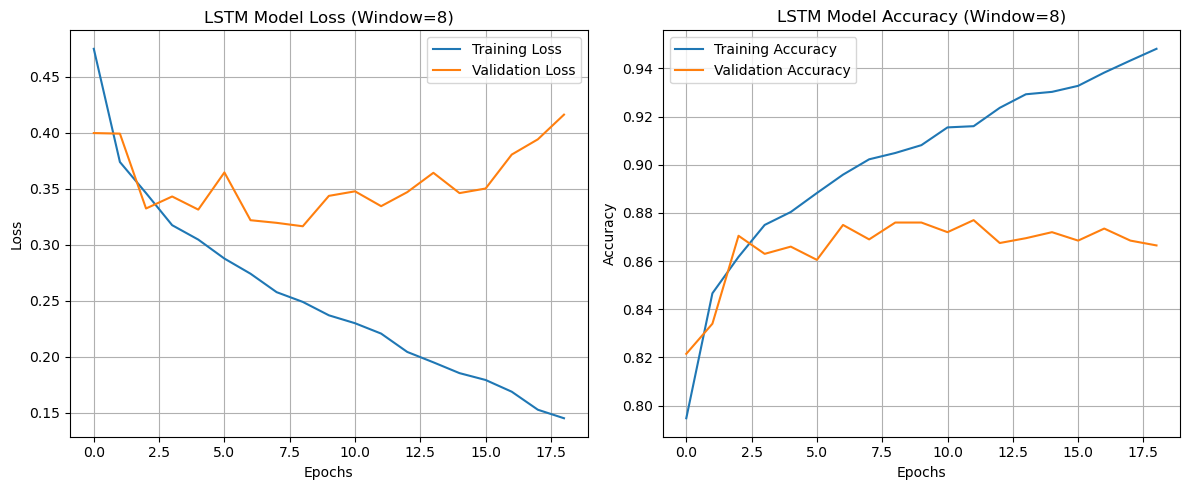

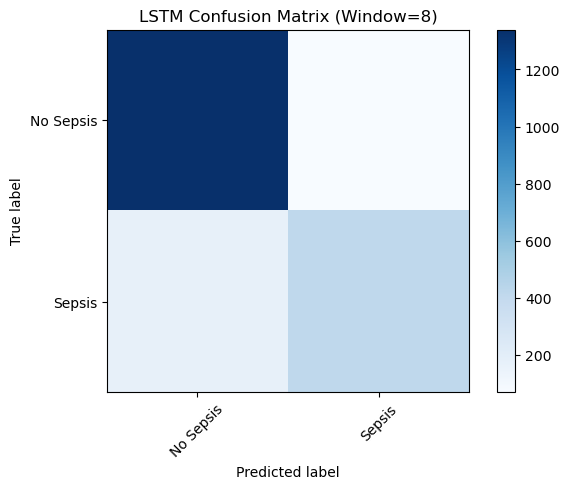

In [121]:
#LSTM implementation model
checkpointer = ModelCheckpoint("lstm_w8-best_weights.keras", verbose=0, save_best_only=True)
best_val_loss = float('inf')
best_model = None

for i in range(5):
    model = Sequential()
    model.add(LSTM(128, input_shape=(WINDOW_SIZE, n_features), return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(32, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )

    monitor = EarlyStopping(
        monitor='val_loss', min_delta=1e-3, patience=10,
        verbose=2, mode='min', restore_best_weights=True
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_test, y_test),
        batch_size=64,
        callbacks=[monitor, checkpointer],
        verbose=1,
        epochs=10000
    )

    val_loss = min(history.history['val_loss'])
    print(f"  Run {i+1} val loss: {val_loss:.4f}")
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model
        print(f"  New best model (val loss: {best_val_loss:.4f})")

#evaluation
print("\n--- Final Evaluation on Test Set ---")
y_pred_prob = best_model.predict(x_test)
y_pred = (y_pred_prob >= 0.5).astype(int).flatten()
print(classification_report(y_test, y_pred, target_names=['No Sepsis', 'Sepsis']))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")

# Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss (Window=8)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy (Window=8)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cm, names=['No Sepsis', 'Sepsis'], title='LSTM Confusion Matrix (Window=8)')
plt.show()